In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from numpy import *
from random import random
import numpy as np
%matplotlib notebook
%load_ext Cython

In [70]:
%%cython
cimport cython

from random import random
import numpy as np
cimport numpy as np

from libc.math cimport exp, sin, cos, sqrt, M_PI

cdef class Particle(object):
    cdef public float x, y, z, vx, vy, vz, dt, m
    cdef public int charge
    def __init__(self, float x0, float y0, float z0, float vx0, float vy0, float vz0, float m, charge=1):
        self.x = x0
        self.y = y0
        self.z = z0

        self.vx = vx0
        self.vy = vy0
        self.vz = vz0
        
        self.m = m
        self.dt = 0.005
        self.charge = charge
    
    cdef float vtotal, vmax
    cpdef _change_velocity(self, float dvx, float dvy, float dvz):
        vmax = 5.
        self.vx += dvx
        self.vy += dvy
        self.vz += dvz
        vtotal = sqrt(self.vx**2 + self.vy**2 + self.vz**2)
        if vtotal > vmax:
            self.vx = self.vx * vmax/vtotal
            self.vy = self.vy * vmax/vtotal
            self.vz = self.vz * vmax/vtotal
            
    cpdef _get_vtotal(self):
        return sqrt(self.vx**2 + self.vy**2 + self.vz**2)

    cpdef step_particle(self):
        self.x += self.vx * self.dt
        self.y += self.vy * self.dt
        self.z += self.vz * self.dt
        
    cpdef _get_charge(self):
        return self.charge    

cdef class Ensemble(object):
    cdef int n, blue_charge, red_charge
    cdef float vseed, x0, y0, z0, vx0, vy0, vz0, x_bound0, x_bound1, y_bound0, y_bound1, z_bound0, z_bound1, drag_coeff, v_in, C
    cdef list particle_array
    cdef public int nblue, nred
    cdef public np.float64_t[:,:] p_array, v_array
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def __cinit__(self, int nblue, int nred, 
                  float x_bound0, float x_bound1, float y_bound0, float y_bound1, float z_bound0, float z_bound1,
                  drag_coeff=0.2, v_in=0.2, C=0.001, blue_charge=-1, red_charge=1):
        self.n = nblue + nred
        self.nblue = nblue
        self.nred = nred
        self.drag_coeff = drag_coeff
        self.C = C
        self.blue_charge = blue_charge
        self.red_charge = red_charge
        self.x_bound0 = x_bound0
        self.x_bound1 = x_bound1
        self.y_bound0 = y_bound0
        self.y_bound1 = y_bound1
        self.z_bound0 = z_bound0
        self.z_bound1 = z_bound1
        self.particle_array = []
        cdef int i
        for i in range(self.n):
            x0 = x_bound0 + (x_bound1 - x_bound0)*random()
            y0 = y_bound0 + (y_bound1 - y_bound0)*random()
            z0 = z_bound0 + (z_bound1 - z_bound0)*random()
            vseedtheta = random() * 2 * M_PI
            vseedphi = random() * M_PI
            vx0 = v_in*cos(vseedtheta)*sin(vseedphi)
            vy0 = v_in*sin(vseedtheta)*sin(vseedphi)
            vz0 = v_in*cos(vseedphi)
            if i < nblue:
                self.particle_array.append(Particle(x0, y0, z0, vx0, vy0, vz0, 1., blue_charge))
            if i >= nblue:
                self.particle_array.append(Particle(x0, y0, z0, vx0, vy0, vz0, 1., red_charge))
        
        self.p_array = np.zeros((self.n, 3), float)
        for i in range(self.n):
            self.p_array[i,0] = self.particle_array[i].x
            self.p_array[i,1] = self.particle_array[i].y
            self.p_array[i,2] = self.particle_array[i].z
    
        self.v_array = np.zeros((self.n, 3), float)
        for i in range(self.n):
            self.v_array[i,0] = self.particle_array[i].vx
            self.v_array[i,1] = self.particle_array[i].vy
            self.v_array[i,2] = self.particle_array[i].vz

    cdef float dt, ep, sig, dx, dy, dz, sep_ij, sdr, l_j_potential, dvx, dvy, dvz, q1q2
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.nonecheck(False)
    cpdef _velocity_update(self): #updating velocities using the lennard-jones potential
        dt = self.particle_array[0].dt
        ep = 0.01 # strength of LJ interactions
        sig = 0.3 # length scale of LJ interactions
        cdef int i, j
        for i in range(self.n):
            for j in range(i+1, self.n): # no double counting or self counting
                dx = self.p_array[i,0] - self.p_array[j,0] # x dist. btwn m1/m2
                dy = self.p_array[i,1] - self.p_array[j,1] # y dist. btwn m1/m2
                dz = self.p_array[i,2] - self.p_array[j,2] # z dist. btwn m1/m2
                sep_ij = sqrt(dx*dx + dy*dy + dz*dz)
                
                if sep_ij <= 2.*sig: #reduces the amount of interactions being evaluated
                    sdr = (sig / sep_ij)**6
                    l_j_potential = 24. * ep/sep_ij * (-2.*sdr**2 + sdr)
                    dvx = -dx/sep_ij * l_j_potential * dt
                    dvy = -dy/sep_ij * l_j_potential * dt
                    dvz = -dz/sep_ij * l_j_potential * dt

                    self.particle_array[i]._change_velocity(dvx,dvy,dvz)
                    self.particle_array[j]._change_velocity(-dvx,-dvy,-dvz)
                    
                    #couloumbic interactions: note the longer range and that they don't exist if too close
                if (sep_ij >= 0.75*sig) and (sep_ij <= 4.*sig):
                    q1q2 = self.particle_array[i]._get_charge() * self.particle_array[j]._get_charge()
                    coul_attr = - 4 * q1q2 * self.C/sep_ij**6 * dt #represents an attractive dipole-dipole interaction
                    dvx = -dx * coul_attr
                    dvy = -dy * coul_attr
                    dvz = -dz * coul_attr
                    self.particle_array[i]._change_velocity(dvx,dvy,dvz)
                    self.particle_array[j]._change_velocity(-dvx,-dvy,-dvz)
        
        # drag so there isn't infinite energy
        for i in range(self.n):
            drag_x = self.drag_coeff * self.particle_array[i].vx * dt
            drag_y = self.drag_coeff * self.particle_array[i].vy * dt
            drag_z = self.drag_coeff * self.particle_array[i].vz * dt
            self.particle_array[i]._change_velocity(-drag_x, -drag_y, -drag_z)
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.nonecheck(False)
    cpdef _time_step(self):
        cdef float eps
        eps = 0.01
        for i in range(self.n):
            m = self.particle_array[i]
            
            # particle boundary crossings
            if m.x <= self.x_bound0:
                m.x = self.x_bound0
                m.vx = -m.vx
                self.v_array[i,0] = self.particle_array[i].vx
            if m.x >= self.x_bound1:
                m.x = self.x_bound1
                m.vx = -m.vx
                self.v_array[i,0] = self.particle_array[i].vx
            if m.y <= self.y_bound0:
                m.y = self.y_bound0
                m.vy = -m.vy
                self.v_array[i,1] = self.particle_array[i].vy
            if m.y >= self.y_bound1:
                m.y = self.y_bound1
                m.vy = -m.vy
                self.v_array[i,1] = self.particle_array[i].vy
            if m.z <= self.z_bound0:
                m.z = self.z_bound0
                m.vz = -m.vz
                self.v_array[i,2] = self.particle_array[i].vz
            if m.z >= self.z_bound1:
                m.z = self.z_bound1
                m.vz = -m.vz
                self.v_array[i,2] = self.particle_array[i].vz
                
            m.step_particle()
            

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.nonecheck(False)
    cpdef _set_p_array(self):
        cdef int i
        for i in range(self.n):
            self.p_array[i,0] = self.particle_array[i].x
            self.p_array[i,1] = self.particle_array[i].y
            self.p_array[i,2] = self.particle_array[i].z

    cpdef _get_p_array(self):
        return self.p_array

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.nonecheck(False)
    cpdef _get_velocity_data(self):
        cdef np.float32_t[:] velocities = np.zeros(self.n, float)
        for i in range(self.n):
            velocities[i] = self.particle_array[i]._get_vtotal()
        return velocities

<IPython.core.display.Javascript object>


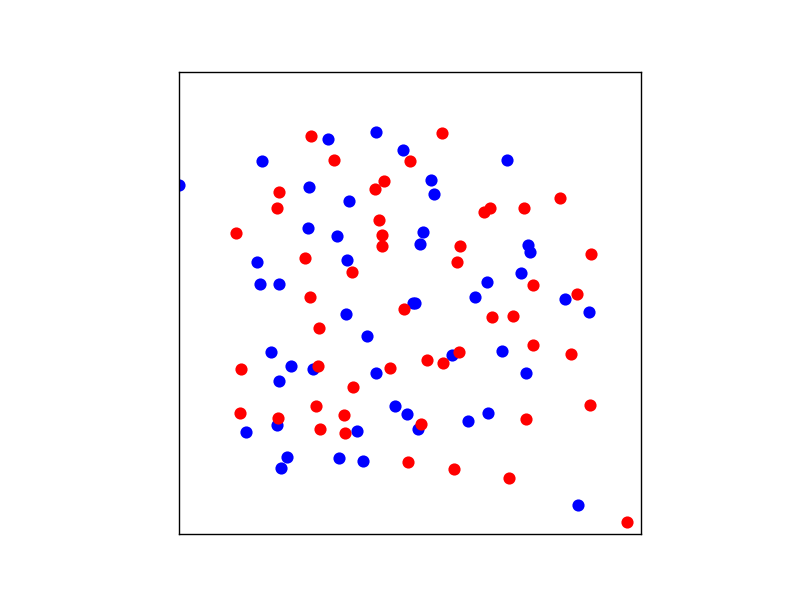

In [103]:
areabound = 2.

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0.,areabound), ylim=(0.,areabound))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

# particles holds the locations of the particles
blueparticles, = ax.plot([], [], 'bo')
redparticles, = ax.plot([], [], 'ro')
en = Ensemble(50, 50, 0., areabound, 0., areabound, 0., areabound, drag_coeff=0.8, v_in=0.2, C=0.0002, red_charge=1)

def init():
    bxpoints = en.p_array[:en.nblue,0]
    bypoints = en.p_array[:en.nblue,1]
    blueparticles.set_data(bxpoints, bypoints)
    rxpoints = en.p_array[en.nblue:,0]
    rypoints = en.p_array[en.nblue:,1]
    redparticles.set_data(rxpoints, rypoints)
    return blueparticles, redparticles

def animate(i):
    en._velocity_update()
    en._time_step()
    en._set_p_array()
    bxpoints = en.p_array[:en.nblue,0]
    bypoints = en.p_array[:en.nblue,1]
    blueparticles.set_data(bxpoints, bypoints)
    rxpoints = en.p_array[en.nblue:,0]
    rypoints = en.p_array[en.nblue:,1]
    redparticles.set_data(rxpoints, rypoints)
    return blueparticles, redparticles

anim = animation.FuncAnimation(fig, animate, frames=10, init_func=init, interval=10)

In [71]:
%timeit Ensemble(100, 100, 0., 3., 0., 3., 0., 3.)._velocity_update()

3.98 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


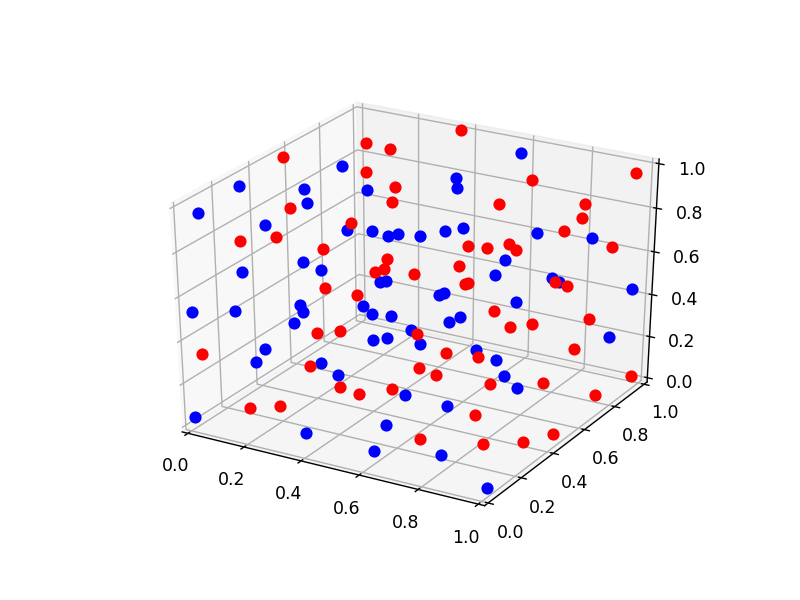

In [116]:
from mpl_toolkits.mplot3d import Axes3D 

areabound = 1.

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xlim=(0.,areabound), ylim=(0.,areabound), zlim=(0.,areabound))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axes.zaxis.set_visible(False)

en = Ensemble(63, 62, 0., areabound, 0., areabound, 0., areabound, drag_coeff=0.9, v_in=0., C=0.002, red_charge=1)

# particles holds the locations of the particles
blueparticles, = ax.plot([],[],[], linestyle='', marker="o", c="b")
redparticles, = ax.plot([],[],[], linestyle='', marker="o", c="r")

def animate(i):
    en._velocity_update()
    en._time_step()
    en._set_p_array()
    bxpoints = en.p_array[:en.nblue,0]
    bypoints = en.p_array[:en.nblue,1]
    bzpoints = np.asarray(en.p_array[:en.nblue,2])
    blueparticles.set_data(bxpoints, bypoints)
    blueparticles.set_3d_properties(bzpoints)
    rxpoints = en.p_array[en.nblue:,0]
    rypoints = en.p_array[en.nblue:,1]
    rzpoints = np.asarray(en.p_array[en.nblue:,2])
    redparticles.set_data(rxpoints, rypoints)
    redparticles.set_3d_properties(rzpoints)
    return blueparticles, redparticles

anim = animation.FuncAnimation(fig, animate, 40, interval=20, blit=True)

In [101]:
print(np.asarray(en.p_array[:en.nblue,2]))
en._velocity_update()
en._time_step()
en._set_p_array()
print(np.asarray(en.p_array[:en.nblue,2]))

[0.32725748 1.37659883 1.61004436 0.48986983 1.90782714 1.57593274
 0.01860744 1.51167154 1.59300077 0.05370705]
[0.32811993 1.37730718 1.60939658 0.49011371 1.90684283 1.57566798
 0.01786805 1.51242363 1.59356427 0.05456105]


<IPython.core.display.Javascript object>


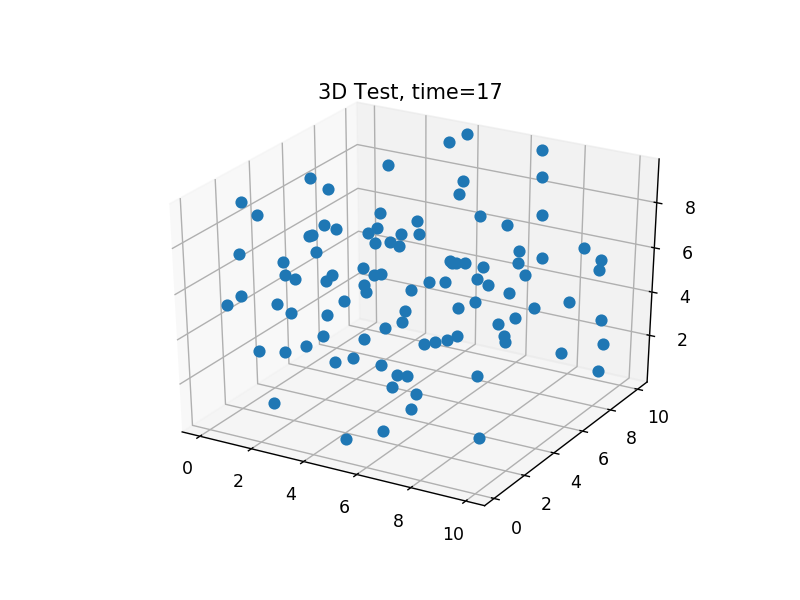

In [95]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd


a = np.random.rand(2000, 3)*10
t = np.array([np.ones(100)*i for i in range(20)]).flatten()
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})

def update_graph(num):
    data=df[df['time']==num]
    graph.set_data (data.x, data.y)
    graph.set_3d_properties(data.z)
    title.set_text('3D Test, time={}'.format(num))
    return title, graph, 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df[df['time']==0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 19, 
                               interval=40, blit=True)

plt.show()